In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 75
BATCH_SIZE = 128
shrink_size = None

p = 0.3 # probability for augmentation
lr = 0.001
weight_deacay = 1e-4
T_max = 10
eta_min = 0.0

# weights for alpha is inverse frequency
# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
alpha = torch.tensor([0.4, 0.4, 0.4, 0.4, 0.4])
gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(p)
test_transforms = helper_functions.get_augmentation_test_transforms(p)
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


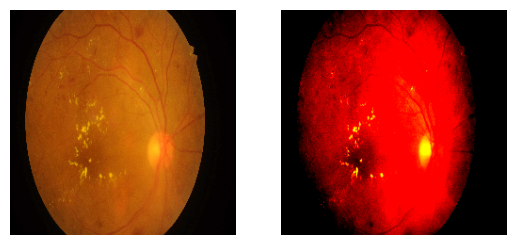

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


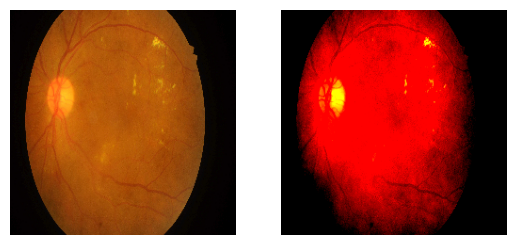

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = ThreeHeadCNN(device=device).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if freeze_encoder:
        for param in model.encoder.parameters():
            param.requires_grad = False

    # Freeze the final head
    for param in model.final_head.parameters():
        param.requires_grad = False

    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        # As the paper has stated, we reinitialize the heads weights
        model.classification_head = nn.Sequential(
                                    nn.Linear(1024, 128),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(128, 5) # 5 output nodes for classification
                                    )
        model.regression_head = nn.Sequential(
                                    nn.Linear(1024, 128),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(128, 1) # 5 output nodes for classification
                                    )
        model.ordinal_head = nn.Sequential(
                                    nn.Linear(1024, 128),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(128, 5) # 5 output nodes for classification
                                    )

In [9]:
prepare_model()

# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   Partial
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 

Custom Focal Loss function

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma, headType=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha.to(device)
        self.gamma = gamma
        self.headType = headType
    def forward(self, inputs, targets):
        
        if self.headType == 'classification':
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha.gather(0, targets)

        if self.headType == 'ordinal':
            ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha

        pt = torch.exp(-ce_loss)
        loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
        return loss.mean()

In [11]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = FocalLoss(headType='classification', alpha=alpha, gamma=gamma).to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.MSELoss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)
# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = FocalLoss(headType='ordinal', alpha=alpha, gamma=gamma).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,       # first restart after 10 epochs
#     T_mult=2,     # double the cycle length each time (10, 20, 40, …)
#     eta_min=1e-6  # minimum learning rate
# )


In [12]:
# # freeze the encode for 5 epochs so that heads get their state

# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.encoder.parameters():
#     param.requires_grad = False

# folds_train_results = {
#     'loss_classification_train': [],
#     'loss_regression_train': [],
#     'loss_ordinal_train': []
# }
# folds_val_results = {
#     'loss_classification_val': [],
#     'loss_regression_val': [],
#     'loss_ordinal_val': []
# }
# if allow_train:
#     # Set the random seeds
#     torch.manual_seed(42)
#     torch.cuda.manual_seed(42)

#     # Start the timer
#     from timeit import default_timer as timer 
#     start_time = timer()

#     # Setup training and save the results
#     for fold in train_val_dataloader:
#         train_results, val_results = engine.train(model=model,
#                             train_dataloader=fold['train_dataloader'],
#                             val_dataloader=fold['val_dataloader'],
#                             optimizer=optimizer,
#                             scheduler=scheduler,
#                             loss_fn_classification=loss_fn_classification,
#                             loss_fn_regression=loss_fn_regression,
#                             loss_fn_ordinal=loss_fn_ordinal,
#                             epochs=5,
#                             device=device)
        
#         folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])
#         folds_train_results['loss_regression_train'].extend(train_results['loss_regression_train'])
#         folds_train_results['loss_ordinal_train'].extend(train_results['loss_ordinal_train'])

#         folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])
#         folds_val_results['loss_regression_val'].extend(val_results['loss_regression_val'])
#         folds_val_results['loss_ordinal_val'].extend(val_results['loss_ordinal_val'])

#     # End the timer and print out how long it took
#     end_time = timer()
#     print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# # Unfreeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.encoder.parameters():
#     param.requires_grad = True

 33%|███▎      | 1/3 [00:30<01:01, 30.95s/it]

Epoch: 0
loss_classification_train: 0.2567 | loss_regression_train: 2.2653 | loss_ordinal_train: 0.0423
loss_classification_validation: 0.2494 | loss_regression_validation: 1.7193 | loss_ordinal_validation: 0.0417
acc_classification_validation: 0.2739 | acc_regression_validation: 0.5312 | acc_ordinal_validation: 0.2818



100%|██████████| 3/3 [00:52<00:00, 17.64s/it]


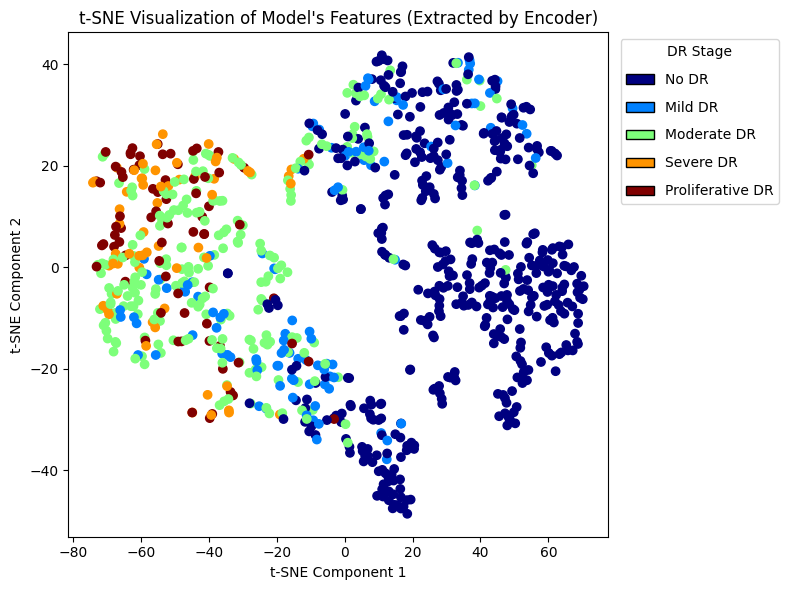

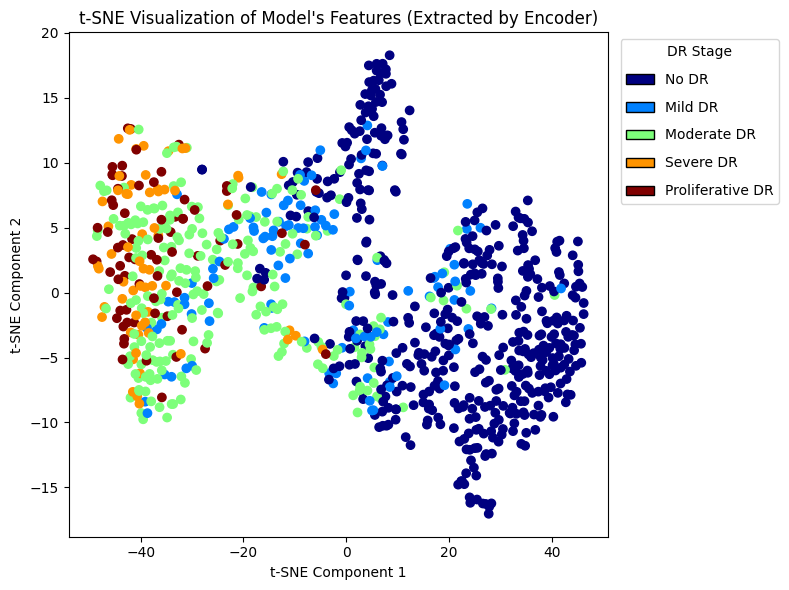

 33%|███▎      | 1/3 [00:30<01:01, 30.74s/it]

Epoch: 0
loss_classification_train: 0.2427 | loss_regression_train: 1.5389 | loss_ordinal_train: 0.0429
loss_classification_validation: 0.1957 | loss_regression_validation: 0.6218 | loss_ordinal_validation: 0.0394
acc_classification_validation: 0.6134 | acc_regression_validation: 0.5304 | acc_ordinal_validation: 0.3131



100%|██████████| 3/3 [00:52<00:00, 17.49s/it]


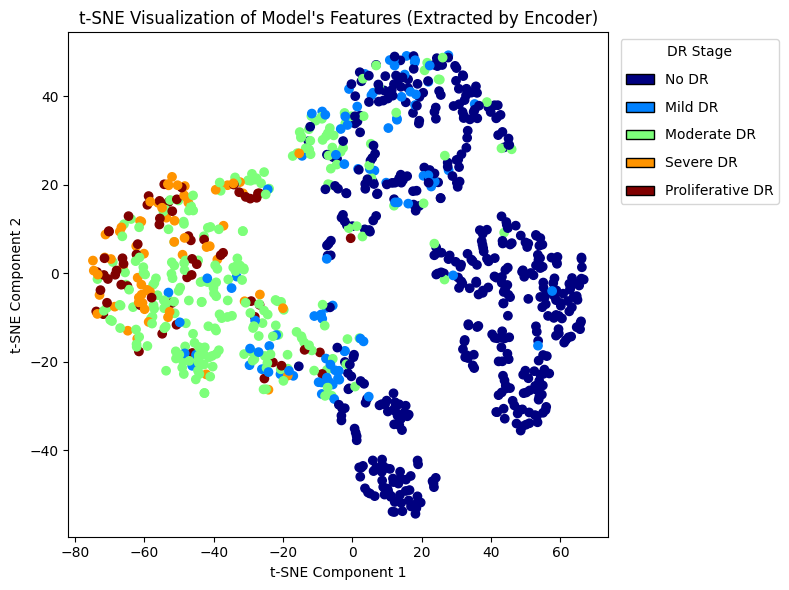

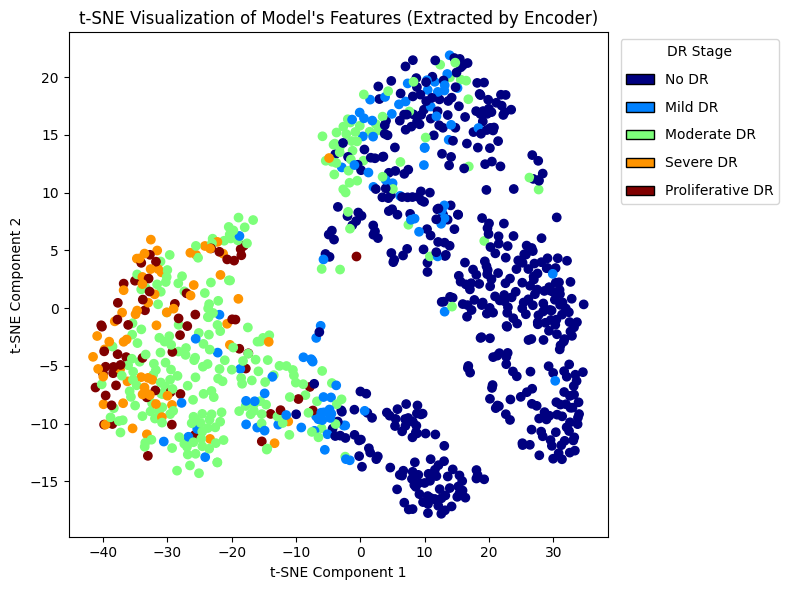

 33%|███▎      | 1/3 [00:30<01:00, 30.31s/it]

Epoch: 0
loss_classification_train: 0.2494 | loss_regression_train: 1.5018 | loss_ordinal_train: 0.0406
loss_classification_validation: 0.2060 | loss_regression_validation: 0.5503 | loss_ordinal_validation: 0.0397
acc_classification_validation: 0.4639 | acc_regression_validation: 0.5559 | acc_ordinal_validation: 0.4346



100%|██████████| 3/3 [00:51<00:00, 17.31s/it]


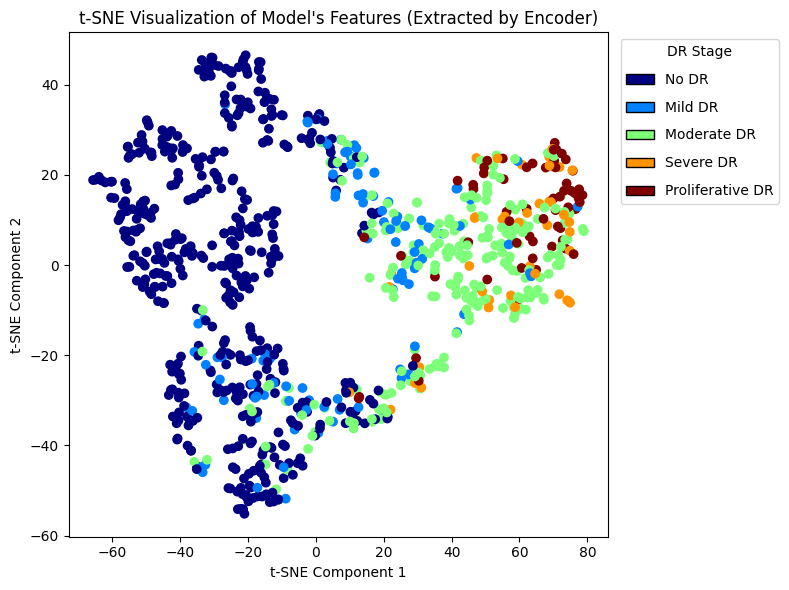

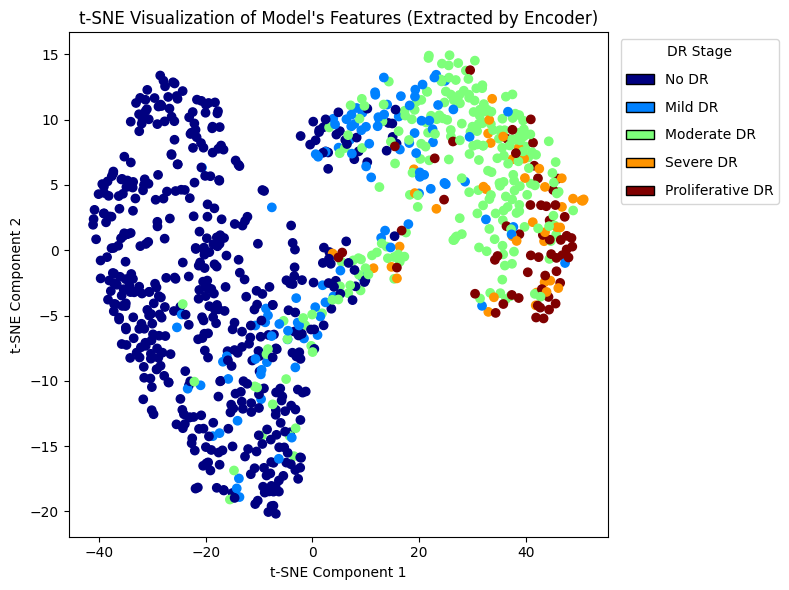

 33%|███▎      | 1/3 [00:30<01:00, 30.33s/it]

Epoch: 0
loss_classification_train: 0.2381 | loss_regression_train: 1.3086 | loss_ordinal_train: 0.0465
loss_classification_validation: 0.2026 | loss_regression_validation: 0.6056 | loss_ordinal_validation: 0.0478
acc_classification_validation: 0.5055 | acc_regression_validation: 0.5701 | acc_ordinal_validation: 0.2256



100%|██████████| 3/3 [00:52<00:00, 17.40s/it]


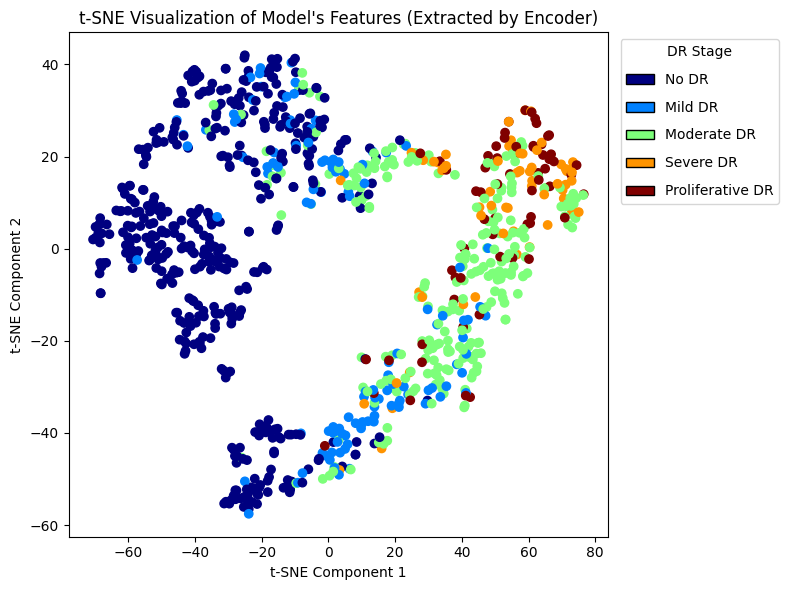

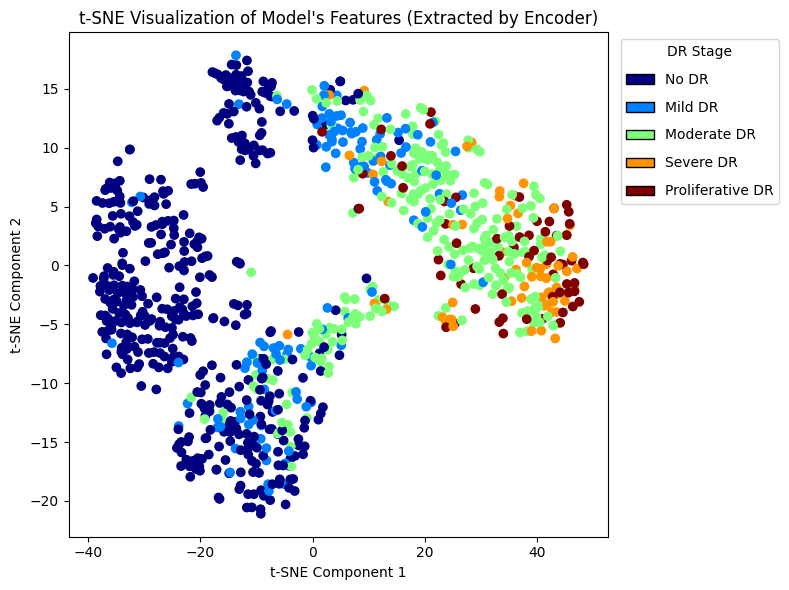

 33%|███▎      | 1/3 [00:30<01:01, 30.73s/it]

Epoch: 0
loss_classification_train: 0.2274 | loss_regression_train: 1.4405 | loss_ordinal_train: 0.0451
loss_classification_validation: 0.1678 | loss_regression_validation: 0.5770 | loss_ordinal_validation: 0.0417
acc_classification_validation: 0.6556 | acc_regression_validation: 0.6195 | acc_ordinal_validation: 0.3103



100%|██████████| 3/3 [00:52<00:00, 17.44s/it]


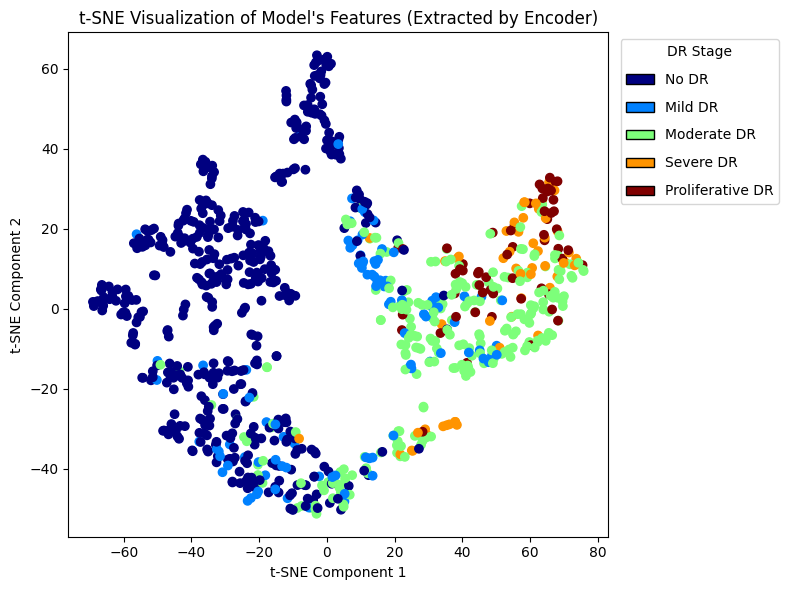

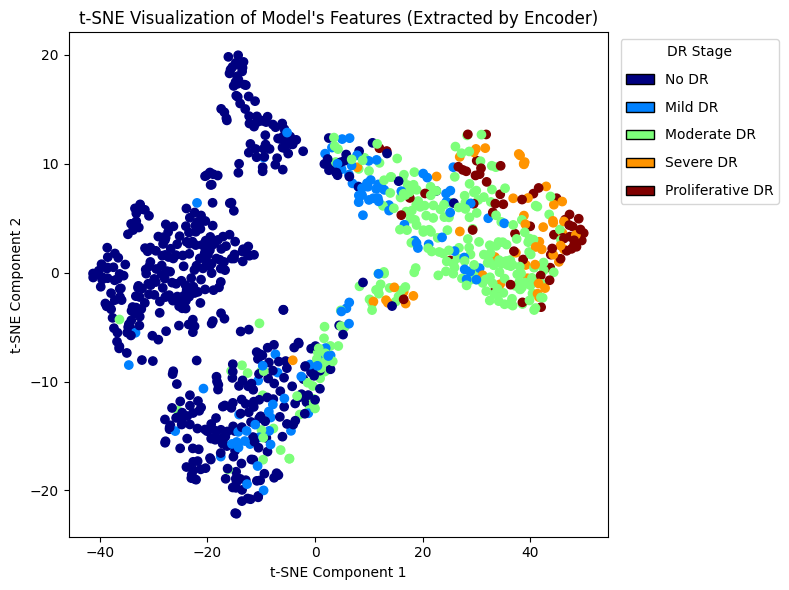

[INFO] Total training time: 285.899 seconds
[INFO] Saving model to: models\main_train_model.pth


In [ ]:
torch.cuda.empty_cache()

folds_train_results = {
    'loss_classification_train': [],
    'loss_regression_train': [],
    'loss_ordinal_train': []
}
folds_val_results = {
    'loss_classification_val': [],
    'loss_regression_val': [],
    'loss_ordinal_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        prepare_model() # restet model's weights to pre train for each fold
        train_results, val_results = engine.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn_classification=loss_fn_classification,
                            loss_fn_regression=loss_fn_regression,
                            loss_fn_ordinal=loss_fn_ordinal,
                            epochs=EPOCHS,
                            device=device)
        
        folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])
        folds_train_results['loss_regression_train'].extend(train_results['loss_regression_train'])
        folds_train_results['loss_ordinal_train'].extend(train_results['loss_ordinal_train'])

        folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])
        folds_val_results['loss_regression_val'].extend(val_results['loss_regression_val'])
        folds_val_results['loss_ordinal_val'].extend(val_results['loss_ordinal_val'])

        helper_functions.plot_t_SNE(model=model,
                                dataloader=fold['val_dataloader'],
                                NUM_ITER=2000)
        
        break

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='main_train_model.pth')
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

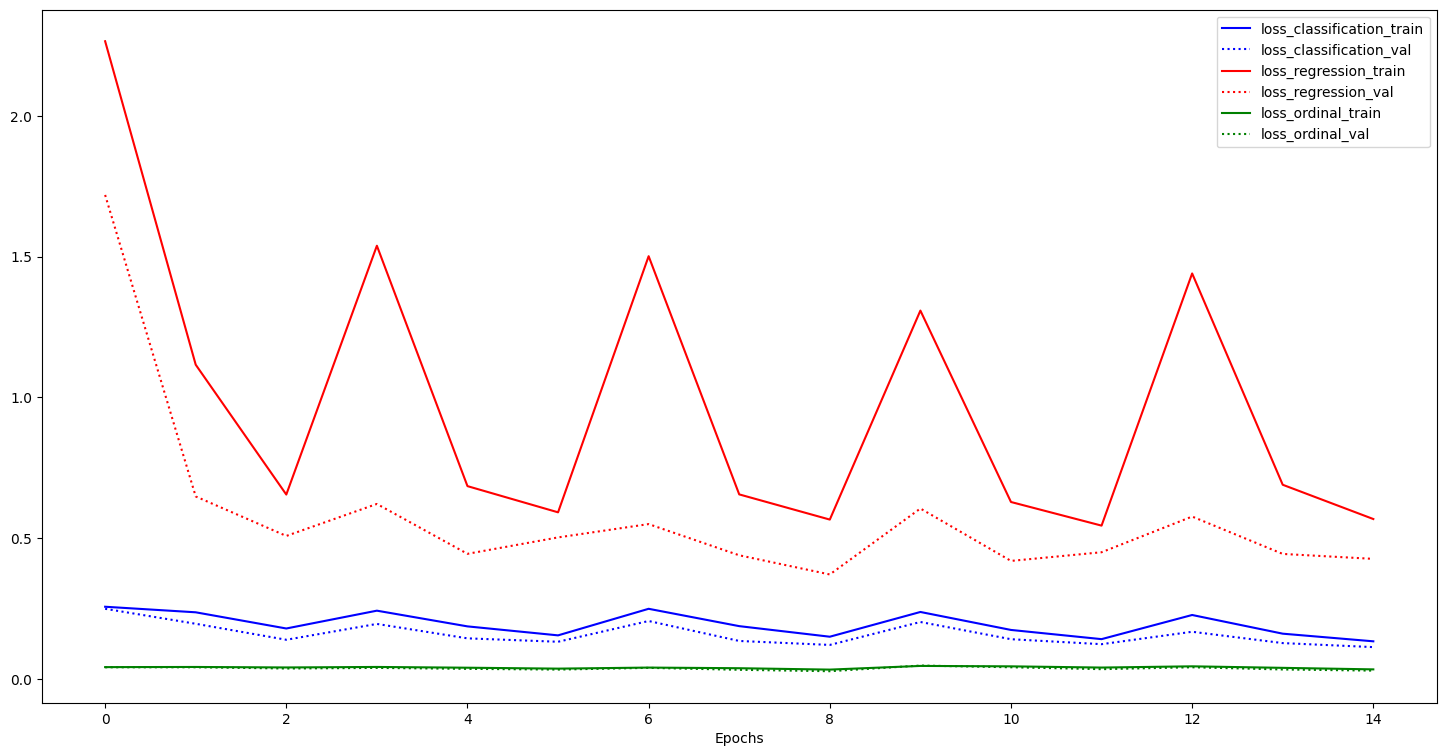

In [14]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(folds_train_results, folds_val_results)

In [15]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)

RuntimeError: bincount only supports 1-d non-negative integral inputs.

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)